In [1]:
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt

from time import time

from numpy import pi
from scipy.integrate import odeint

import gprob as gp
from gprob import normal

from gprob.fft import fft 

# Time-domain

In [2]:
# A damped harmonic oscillator

gamma_m = 0.01
omega_m = 1

sys_mat = np.array([[0., omega_m], 
                    [-omega_m, -gamma_m]])

t = np.linspace(0, 200, 2*10**3)

def eqs(y, t):
    return np.dot(sys_mat, y)

t0 = time()
y0 = np.eye(sys_mat.shape[0])
green = [odeint(eqs, y0_, t).reshape((len(t), sys_mat.shape[0], 1)) for y0_ in y0]
green = np.concatenate([s.reshape((len(t), sys_mat.shape[0], 1)) for s in green], axis=-1)

print(f"Solution time: {time() - t0:0.3f} s")

Solution time: 0.026 s


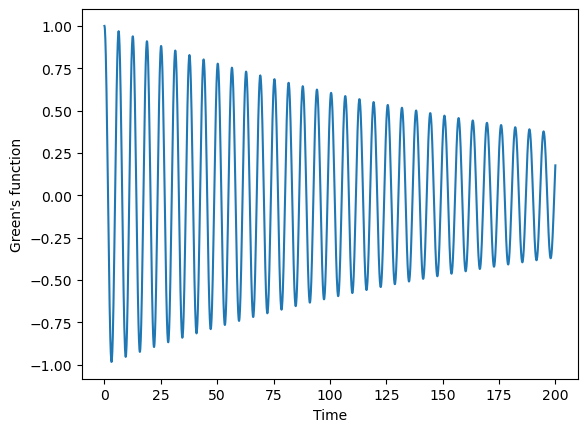

In [3]:
plt.plot(t, green[:, 0, 0])
plt.xlabel("Time")
plt.ylabel("Green's function");

In [4]:
green_inv = np.linalg.inv(green)

in_noise = normal(size=(len(t), 2))

tmp = gp.einsum("ikj, ij -> ik", green_inv, in_noise)
tmp2 = gp.cumsum(tmp, axis=0)
noisy_sol = gp.einsum("ikj, ij -> ik", green, tmp2)

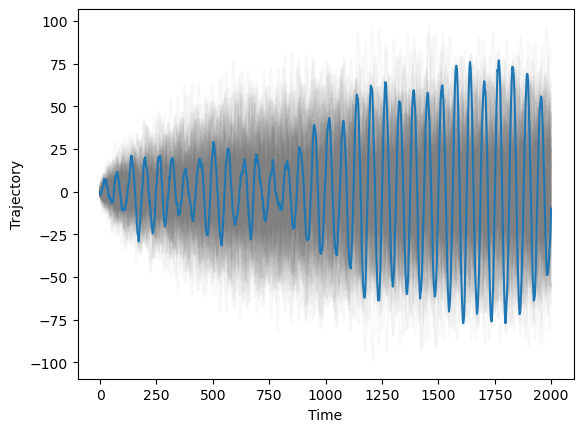

In [5]:
plt.plot(noisy_sol.sample(200)[:, :, 0].T, color='gray', alpha=0.05)  #TODO: fix indexing
plt.plot(noisy_sol.sample()[:, 0])
plt.xlabel("Time")
plt.ylabel("Trajectory");

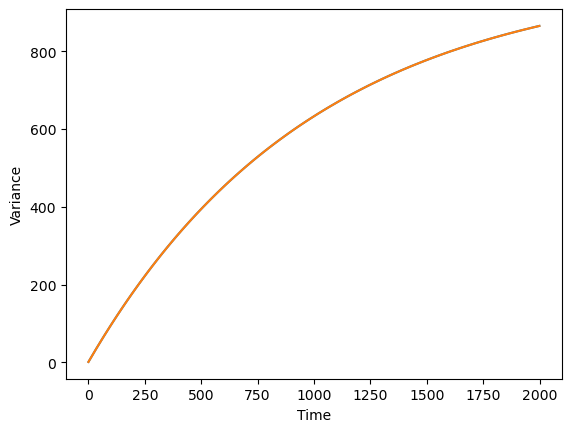

In [6]:
plt.plot(noisy_sol.var());
plt.xlabel("Time")
plt.ylabel("Variance");

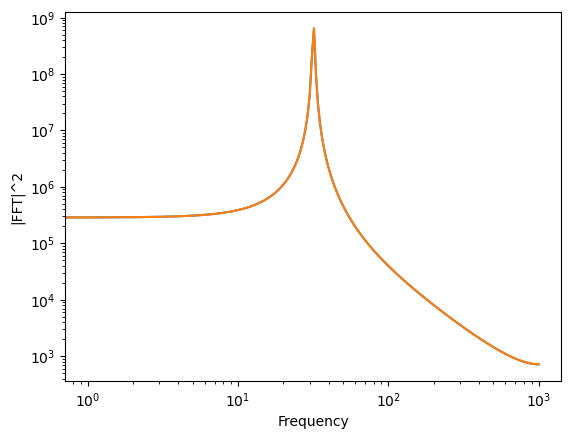

In [7]:
# The spectra of x and p of the oscilaltor. 

four = fft(noisy_sol, axis=0)

plt.plot(four.var()[:len(t)//2])
plt.yscale("log")
plt.xscale("log")

plt.xlabel("Frequency")
plt.ylabel("|FFT|^2");

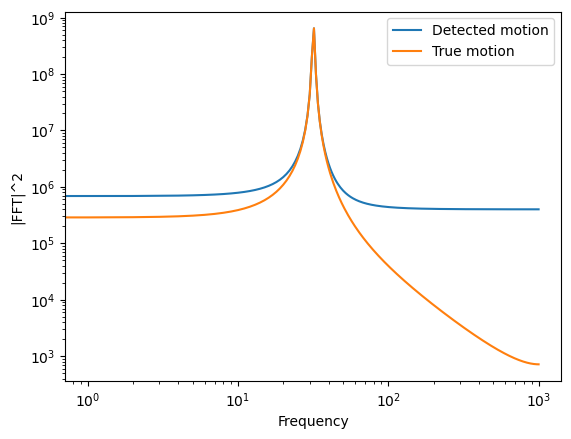

In [8]:
readout_noise = normal(0, 200, size=len(t))  # White detection noise.

det_sig = readout_noise + noisy_sol[:, 0]
four_det = fft(det_sig, axis=0)  # detected signal

plt.plot(four_det.var()[:len(t)//2], label="Detected motion")
plt.plot(four.var()[:len(t)//2, 0], label="True motion")
plt.yscale("log")
plt.xscale("log")
plt.legend()

plt.xlabel("Frequency")
plt.ylabel("|FFT|^2");

In [9]:
# Conditioning the oscillator motion on the measurement record.

t0 = time()
cond_noisy_sol = noisy_sol | {det_sig: 0}
print(f"Conditioning time: {time() - t0:0.3f} s")

Conditioning time: 5.522 s


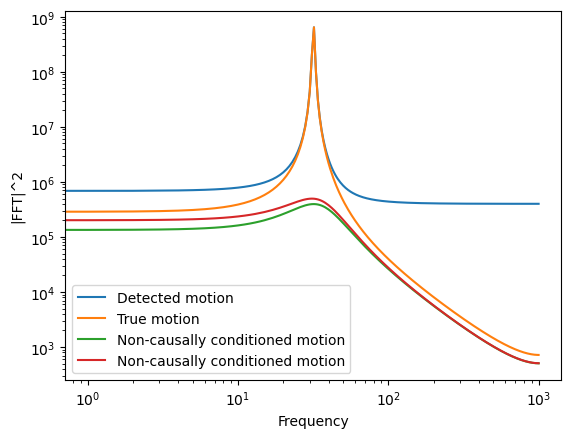

In [10]:
four_cond = fft(cond_noisy_sol, axis=0)

plt.plot(four_det.var()[:len(t)//2], label="Detected motion")
plt.plot(four.var()[:len(t)//2, 0], label="True motion")
plt.plot(four_cond.var()[:len(t)//2], label="Non-causally conditioned motion")
plt.yscale("log")
plt.xscale("log")
plt.legend()

plt.xlabel("Frequency")
plt.ylabel("|FFT|^2");

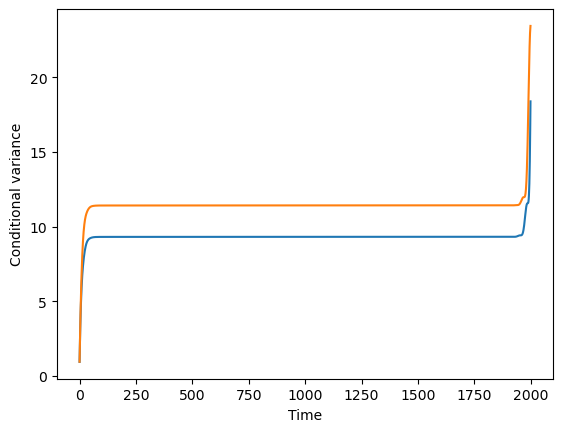

In [11]:
plt.plot(cond_noisy_sol.var())
plt.xlabel("Time")
plt.ylabel("Conditional variance");

In [12]:
# Causal conditioning using a mask.

n = len(t)
cmask = np.tri(len(t), len(t), dtype=bool).T

t0 = time()
caus_cond_noisy_sol = noisy_sol.condition({det_sig: 0}, mask=cmask)
print(f"Conditioning time: {time() - t0:0.3f} s")

Conditioning time: 5.690 s


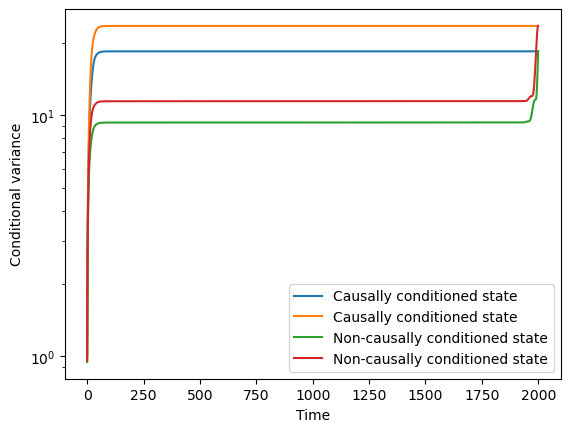

In [13]:
plt.plot(caus_cond_noisy_sol.var(), label="Causally conditioned state")
plt.plot(cond_noisy_sol.var(), label="Non-causally conditioned state")
plt.yscale("log")
plt.legend()

plt.xlabel("Time")
plt.ylabel("Conditional variance");

In [14]:
# Anti-causal conditioning.

n = len(t)
amask = np.tri(len(t), len(t), -1, dtype=bool)

t0 = time()
acaus_cond_noisy_sol = noisy_sol.condition({det_sig: 0}, mask=amask)
print(f"Conditioning time: {time() - t0:0.3f} s")

Conditioning time: 7.179 s


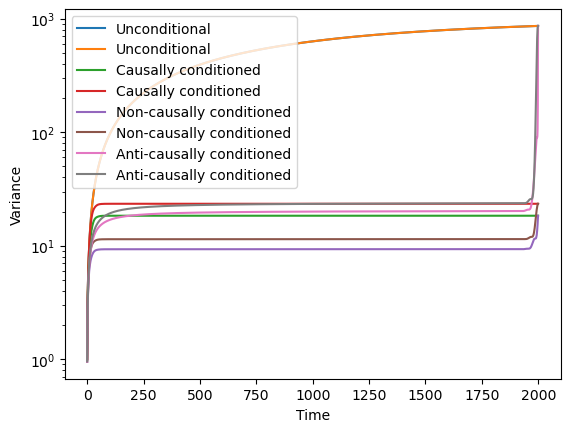

In [15]:
plt.plot(noisy_sol.var(), label="Unconditional")
plt.plot(caus_cond_noisy_sol.var(), label="Causally conditioned")
plt.plot(cond_noisy_sol.var(), label="Non-causally conditioned")
plt.plot(acaus_cond_noisy_sol.var(), label="Anti-causally conditioned")
plt.yscale("log")
plt.legend()

plt.xlabel("Time")
plt.ylabel("Variance");

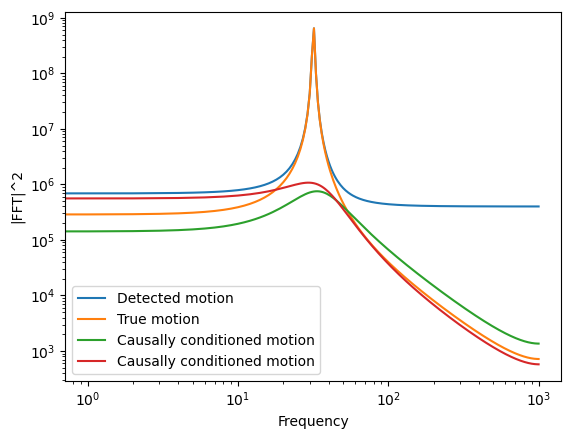

In [16]:
# Fourier domain.

four_caus_cond = fft(caus_cond_noisy_sol, axis=0)

plt.plot(four_det.var()[:len(t)//2], label="Detected motion")
plt.plot(four.var()[:len(t)//2, 0], label="True motion")
plt.plot(four_caus_cond.var()[:len(t)//2], label="Causally conditioned motion")
plt.yscale("log")
plt.xscale("log")
plt.legend()

plt.xlabel("Frequency")
plt.ylabel("|FFT|^2");